**Chapter 6: Enhancing and Segmenting Images**
# Semantic Segmentation for Smart Cars with FCN-8s

After preparing the Cityscapes dataset in the previous notebook, it is time to train a segmentation model on it.
In this notebook, we will re-implement the **_FCN-8s_** architecture ourselves, and apply to to the semantic segmentation of urban scenes. In a second time, we will present how to guide the network so it does not ignore smaller elements, by implementing several **loss weighing strategies**.

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]= "2"

## Preparing the Dataset

We dedicated the previous [notebook](./ch6_nb4_data_preparation_for_smart_car_apps.ipynb) to setting up the input pipeline for the Cityscapes data[$^1$](#ref). It is now just a matter of importing our helper functions and instantiate our `tf.data.Dataset` accordingly: 

In [2]:
from cityscapes_utils import (
    CITYSCAPES_FOLDER, # change this variable to Cityscapes root folder
    CITYSCAPES_LABELS, CITYSCAPES_IGNORE_VALUE, 
    cityscapes_input_fn, get_cityscapes_file_pairs, 
    postprocess_to_show)

In [3]:
# Key variables:
batch_size     = 16
num_epochs     = 90
image_size     = [512, 512]
num_channels   = 3
num_classes    = len(CITYSCAPES_LABELS)
random_seed    = 1
num_show       = 3

In [4]:
num_train_imgs = len(get_cityscapes_file_pairs(split='train', 
                                               root_folder=CITYSCAPES_FOLDER)[0])
num_val_imgs   = len(get_cityscapes_file_pairs(split='val', 
                                               root_folder=CITYSCAPES_FOLDER)[0])

train_dataset = cityscapes_input_fn(
    root_folder=CITYSCAPES_FOLDER, resize_to=image_size, batch_size=batch_size,
    shuffle=True, num_epochs=num_epochs, augment=True, seed=random_seed)
val_dataset = cityscapes_input_fn(
    root_folder=CITYSCAPES_FOLDER, resize_to=image_size, batch_size=batch_size,
    shuffle=True, num_epochs=None, augment=False, seed=random_seed)
    # normally we wouldn't shuffle the validation dataset
    # (it is a costly operation, with no effect on the validation results),
    # but we will also use this dataset to render some random results... 

train_iterator = train_dataset.make_one_shot_iterator()
train_images, train_labels = train_iterator.get_next()
val_iterator = val_dataset.make_one_shot_iterator()
val_images, val_labels = val_iterator.get_next()

# Making sure Keras will use the same session as the one TF just intantiated for the data pipeline:
session = tf.Session()
tf.keras.backend.set_session(session)

In [5]:
import math

# Number of batches per train/val epoch, to guide the Keras `fit` method:
train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(num_val_imgs / batch_size)

## Building a FCN-8s Model for Semantic Segmentation

In Chapter 6, we presented the **_FCN_ architectures**[$^2$](#ref) (already briefly introduced in Chapter 4). We will now implement our own version, and train it to segment our urban images:

### FCN-8s architecture

As detailed in the book, _FCN_ models have been developed for semantic segmentation. Based on **_VGG-16_**[$^3$](#ref), they use this network as _feature extractor_ (c.f. Chapter 4), adding on top some layers to concatenate and upsample the feature maps into pixel-level predictions.

To purely focus on the architecture, we will once again use the Keras high-level API to create our model:

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *

In [7]:
# Network hyper-parameters:
kernel_size    = 3
filters_orig   = 16
layer_depth    = 4
use_batch_norm = batch_size > 1

The _FCN_ architecture is as follow (c.f. details in Chapter 6):

![FCN Architecture](./notebook_images/fcn.png)

Using the pre-trained _VGG-16_ network provided by Keras, we extend at according to this figure:

In [8]:
def fcn_8s(image_size, ch_in=3, ch_out=3):
    """
    Build a FCN-8s Keras model, with the VGG-16 layers pretrained on ImageNet.
    :param image_size:  Image size (H x W)
    :param ch_in:       Number of input channels
    :param ch_out:      Number of output channels
    :return:            Keras model
    """
    
    inputs = Input(shape=(*image_size, ch_in), name='input')

    # Building a pre-trained VGG-16 feature extractor (i.e., without the final FC layers)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    # Recovering the feature maps generated by each of the 3 final blocks:
    f3 = vgg16.get_layer('block3_pool').output  # shape: (28, 28, 256)
    f4 = vgg16.get_layer('block4_pool').output  # shape: (14, 14, 512)
    f5 = vgg16.get_layer('block5_pool').output  # shape: ( 7,  7, 512)

    # Replacing VGG dense layers by convolutions:
    f5_conv1 = Conv2D(filters=4086, kernel_size=7, padding='same',
                      activation='relu')(f5)
    f5_drop1 = Dropout(0.5)(f5_conv1)
    f5_conv2 = Conv2D(filters=4086, kernel_size=1, padding='same',
                      activation='relu')(f5_drop1)
    f5_drop2 = Dropout(0.5)(f5_conv2)
    f5_conv3 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f5_drop2)


    # Using a transposed conv (w/ s=2) to upscale `f5` into a 14 x 14 map
    # so it can be merged with features from `f4_conv1` obtained from `f4`:
    f5_conv3_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(f5)
    f4_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f4)

    # Merging the 2 feature maps (addition):
    merge1 = add([f4_conv1, f5_conv3_x2])

    # We repeat the operation to merge `merge1` and `f3` into a 28 x 28 map:
    merge1_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(merge1)
    f3_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f3)
    merge2 = add([f3_conv1, merge1_x2])

    # Finally, we use another transposed conv to decode and up-scale the feature map
    # to the original shape, i.e., using a stride 8 to go from 28 x 28 to 224 x 224 here:
    outputs = Conv2DTranspose(filters=ch_out, kernel_size=16, strides=8,
                              padding='same', activation=None)(merge2)
    
    fcn8s_model = Model(inputs, outputs)
    return fcn8s_model

 We can now instantiate our model for semantic segmentation, i.e., returning $H \times W \times N$ tensors (with $H, W$ image size, $N$ the number of classes). For each pixel, the $N$ predicted values/logits represent the network's belief that this pixel belongs to the classes (the higher one of the values, the more probable the pixel belongs to the corresponding class according to the model).

In [9]:
fcn8s_model = fcn_8s(image_size, num_channels, num_classes)
fcn8s_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

As we know already from Chapter 4, _VGG_ is a rather heavy architecture (c.f. number of parameters). Nevertheless, most of the layers composing our model have been pre-trained on ImageNet already, which will simplify the training for our new task.

### Loss and Metrics

We have the model and data ready. However before starting training, we will set up some additional visualization tools, and more importantly define our training loss.

Let us start with the loss.
As mentioned already, semantic segmentation is nothing but **classification at the pixel-level** (instead of image-level). Therefore, the same loss function can be used: _**cross-entropy**_.

However, in our Cityscapes experiment, we decided to ignore some of the classes present in the label maps (i.e., the misc. classes with `trainID != 255` c.f. previous notebook). We have therefore two choices: 

- Either we consider all the ignored elements as belonging to a 20th `void` class, and ask the network to correctly assign the corresponding pixels to the 20th class;
- Or we completely ignore the corresponding pixels, and do not penalize our network for misclassifying them.

The Cityscapes [benchmarks](https://www.cityscapes-dataset.com/benchmarks/) evaluate models based on the second strategy, so will we.

To do so, before computing the cross-entropy, we will process our predictions and ground-truths to **mask out the pixels belonging to the ignored classes** in the ground-truth maps. This is the purpose of the function `prepare_data_for_loss()` below, which builds a mask of valid pixels from the ground-truth maps, and then uses that mask to keep only these pixels in both tensors:

In [10]:
def get_mask_for_valid_labels(y_true, num_classes, ignore_value=CITYSCAPES_IGNORE_VALUE):
    """
    Build a mask for the valid pixels, i.e. those not belonging to the ignored classes.
    :param y_true:        Ground-truth label map(s) (each value represents a class trainID)
    :param num_classes:   Total nomber of classes
    :param ignore_value:  trainID value of ignored classes (`None` if ignored none) 
    :return:              Binary mask of same shape as `y_true`
    """
    mask_for_class_elements = y_true < num_classes
    mask_for_not_ignored = y_true != ignore_value
    mask = mask_for_class_elements & mask_for_not_ignored
    return mask


def prepare_data_for_segmentation_loss(y_true, y_pred, 
                                       num_classes=10, ignore_value=CITYSCAPES_IGNORE_VALUE):
    """
    Prepare predicted logits and ground-truth maps for the loss, removing pixels from ignored classes.
    :param y_true:        Ground-truth label map(s) (e.g., of shape B x H x W)
    :param y_pred:        Predicted logit map(s) () (e.g., of shape B x H x W x N, N number of classes)
    :param num_classes:   Number of classes
    :param ignore_value:  trainID value of ignored classes (`None` if ignored none) 
    :return:              Tensors edited, ready for the loss computation
    """

    with tf.name_scope('prepare_data_for_loss'):
        # Flattening the tensors to simplify the following operations:
        if len(y_pred.shape) > (len(y_true.shape) - 1):
            y_pred = tf.reshape(y_pred, [-1, num_classes])
        else:
            y_pred = tf.reshape(y_pred, [-1])
        y_true = tf.reshape(tf.to_int32(y_true), [-1])

        if ignore_value is not None:
            # To compare only on the considered class, we remove all the elements in the images
            # belonging to the ignored ones.
            # For that, we first compute the mask of the pixels belonging to valid labels:
            mask_for_valid_labels = get_mask_for_valid_labels(
                y_true, num_classes, ignore_value=ignore_value)
    
            # Then we use this mask to remove all pixels/elements not belonging to valid classes:
            y_true = tf.boolean_mask(y_true, mask_for_valid_labels, axis=0, name='gt_valid')
            y_pred = tf.boolean_mask(y_pred, mask_for_valid_labels, axis=0, name='pred_valid')

    return y_true, y_pred

To be able to apply this pre-processing before computing the loss, we implement our own custom loss function. The cross-entropy is computed as usual, but only after applying the method we just built:

In [11]:
def segmentation_loss(y_true, y_pred, ignore_value=CITYSCAPES_IGNORE_VALUE):
    """
    Compute the cross-entropy loss for semantic segmentation, ignoring pixels from some misc. classes.
    :param y_true:        Ground-truth label map(s) (e.g., of shape B x H x W)
    :param y_pred:        Predicted logit map(s) () (e.g., of shape B x H x W x N, N number of classes)
    :param ignore_value:  trainID value of ignored classes (`None` if ignored none) 
    :return:              Loss
    """
    with tf.name_scope('segmentation_loss'):
        num_classes = y_pred.shape[-1]
        y_true, y_pred = prepare_data_for_segmentation_loss(y_true, y_pred,
                                                            num_classes=num_classes, 
                                                            ignore_value=ignore_value)

        loss = tf.losses.sparse_softmax_cross_entropy(labels=y_true, logits=y_pred,
                                                      reduction=tf.losses.Reduction.MEAN)
    return loss

Similarly, if we want to compute the accuracy as metric (i.e., the percent of correctly classified pixels), we need to edit the default method to ignore the pixels belonging to our misc. classes:

In [12]:
def segmentation_accuracy(y_true, y_pred, ignore_value=CITYSCAPES_IGNORE_VALUE):
    """
    Compute the accuracy, ignoring pixels from some misc. classes.
    :param y_true:        Ground-truth label map(s) (e.g., of shape B x H x W)
    :param y_pred:        Predicted logit map(s) () (e.g., of shape B x H x W x N, N number of classes)
    :param ignore_value:  trainID value of ignored classes (`None` if ignored none) 
    :return:              Tensors edited, ready for the loss computation
    """
    with tf.name_scope('segmentation_accuracy'):
        num_classes = y_pred.shape[-1]
        y_pred = tf.to_int32(tf.argmax(y_pred, axis=-1))
        y_true, y_pred = prepare_data_for_segmentation_loss(y_true, y_pred, 
                                                            num_classes=num_classes, 
                                                            ignore_value=ignore_value)

        num_pixels_to_classify = tf.size(y_true)
        num_pixels_correct = tf.reduce_sum(tf.to_int32(tf.equal(y_true, y_pred, name='correct')))

        accuracy = tf.to_float(num_pixels_correct) / tf.to_float(num_pixels_to_classify)
        return accuracy
segmentation_accuracy.__name__ = "acc"

Additionally, we will also implement the _**Intersection-over-Union (IoU)**_ metric. Unlike the accuracy above, the _IoU_ does not under-represent classes which are covering smaller areas in the images (c.f. Chapters 5 and 6).

Luckily for us, TensorFlow has its own implementation of the mean _IoU_ (_IoU_ for multi-class predictions, averaging the _IoU_ computed for each clas separately). However, TensorFlow metrics cannot be directly passed to Keras `fit` method, as they sometimes depend on hidden variables which need to be initialized/re-initialized after each epoch. Adapting TensorFlow metrics for Keras models is thus not straightforward, but thankfully the following _hack_ was proposed: 

In [13]:
def initialize_variables():
    """
    Initialize uninitialized variables on the fly.
    Snippet by JihongJu (https://github.com/JihongJu/keras-fcn/blob/master/keras_fcn/metrics.py)
    """
    variables = tf.local_variables()
    uninitialized_variables = []
    for v in variables:
        if not hasattr(v, '_keras_initialized') or not v._keras_initialized:
            uninitialized_variables.append(v)
            v._keras_initialized = True
    if uninitialized_variables:
        sess = tf.keras.backend.get_session()
        sess.run(tf.variables_initializer(uninitialized_variables))


def adapt_tf_streaming_metric_for_keras(tf_metric, name,
                                        preprocss_fn=None, postprocess_fn=None,
                                        **kwargs):
    """
    Wrap a TensorFlow metric into a partial function which can be passed to Keras models.
    :param tf_metric:      TensorFlow metric which should be wrapped (e.g. `tf.metrics.mean_iou`)
    :param name:           Should be the name of the TF metric function.
                           (e.g. for `tf.metrics.mean_iou`, `name` should be "mean_iou")
    :param preprocss_fn:   (opt.) Function to pre-process `y_true`, `y_pred`
    :param postprocess_fn: (opt.) Function to post-process the metric value
    :return:               Metric function compatible wth Keras
    """

    # Inspired from snipped by Ruzhitskiy Bogdan
    # (https://github.com/keras-team/keras/issues/6050#issuecomment-329996505)
    def metric(y_true, y_pred):
        """ Wrap a TF metric, instantiating hidden variables + updating hidden states"""

        # First we define the metric operation:
        value, update_op = tf_metric(y_true, y_pred, **kwargs)

        # It is possible that the metric is relying on some local variables,
        # that we should then initialize them:
        initialize_variables()

        # Finally, we force the update of the metric values:
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
            return value

    def metric_with_pre_and_post_processing(y_true, y_pred):
        """ Wrapper to pre/post-process the data"""

        if preprocss_fn is not None:
            y_true, y_pred = preprocss_fn(y_true, y_pred)

        value = metric(y_true, y_pred)

        if postprocess_fn is not None:
            value = postprocess_fn(y_true, y_pred, value)

        return value

    metric_with_pre_and_post_processing.__name__ = name

    return metric_with_pre_and_post_processing

We can now create a wrapper to instantiate the _IoU_ metric:

In [14]:
def mean_iou_metric(num_classes, ignore_value=CITYSCAPES_IGNORE_VALUE):
    """
    Return a IoU metric function for Keras models.
    :param num_classes:   Number of target classes
    :return:              Metric function compatible wth Keras
    :param ignore_value:  trainID value of ignored classes (`None` if ignored none) 
    """

    def preprocess_for_mean_iou(y_true, y_pred):
        # Like for other metrics/losses, we remove the values for the ignored class(es):
        y_true, y_pred = prepare_data_for_segmentation_loss(y_true, y_pred,
                                                            num_classes=num_classes, 
                                                            ignore_value=ignore_value)
        # And since tf.metrics.mean_iou() needs the label maps, not the one-hot versions,
        # we adapt accordingly:
        y_pred = tf.argmax(y_pred, axis=-1)
        # (y_true is already as a label map)

        return y_true, y_pred

    metric = adapt_tf_streaming_metric_for_keras(
        tf.metrics.mean_iou, "mean_iou", num_classes=num_classes,
        preprocss_fn=preprocess_for_mean_iou)

    return metric

# Usage example:
# model.compile(loss=segmentation_loss, metrics=[mean_iou_metric(num_classes)])

### Other training helpers

To visualize some samples before/after training, we build a method to predict and post-process the results. This means **converting the logit maps into probabilities** (`softmax`), **selecting the most probable class for each pixel** (`argmax`), then **converting the predicted label maps into RGB label images for visualization**. We also process the input images and target labels (e.g. scaling them back to normal):

In [15]:
from plot_utils import plot_image_grid

def predict_and_postprocess(images, gt_labels):
    """
    Use the model to predict the label map, and post-process the data for visualization.
    :param images:      Images
    :param gt_labels:   Ground-truth label maps
    :return:            Images, predicted label maps and GT label maps ready for display
    """

    predicted_onehot = fcn8s_model(images)

    # We convert the predicted logits into categorical results
    # (i.e for each pixel, we assign the class corresponding to the largest logit/probability):
    predicted = tf.math.argmax(predicted_onehot, axis=-1)
    predicted = tf.expand_dims(predicted, axis=-1)

    # Then we post-process the tensors for display:
    images_show, predicted_show, gt_show = postprocess_to_show(
        images, predicted, gt_labels, one_hot=True)
    
    return images_show, predicted_show, gt_show

/home/benjamin/anaconda3/envs/main/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


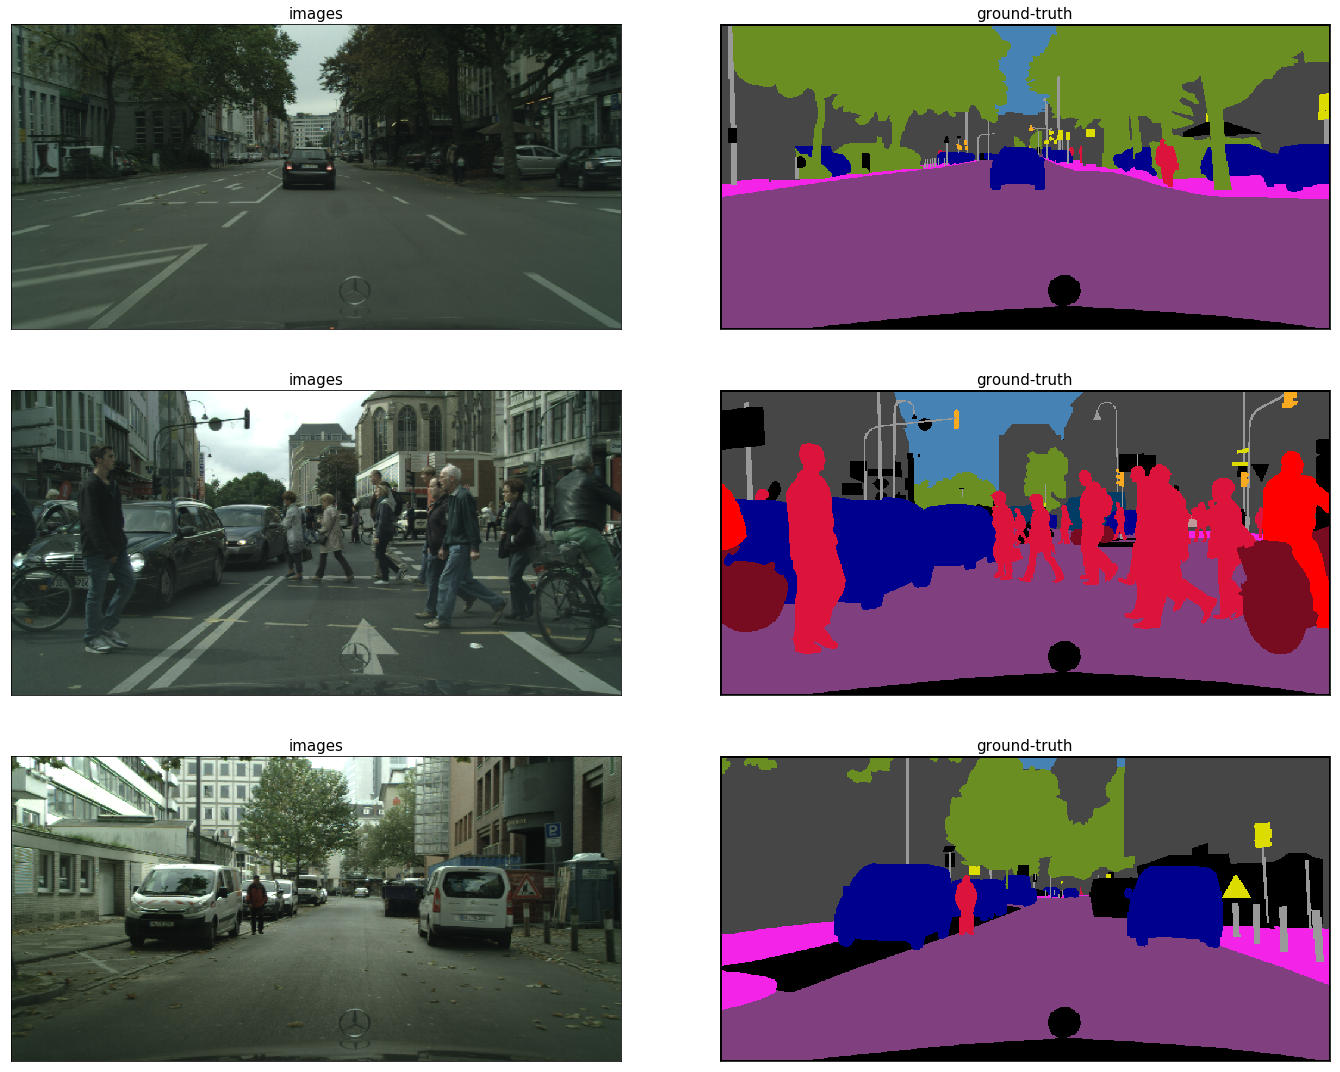

In [16]:
# Simply visualizing the input/target pairs for now:

image_show, predicted_show, gt_show = predict_and_postprocess(val_images, val_labels)
input_samples, target_samples, input_show, target_show = session.run(
    [val_images, val_labels, image_show, gt_show])
input_samples, target_samples = input_samples[:num_show], target_samples[:num_show]
input_show, target_show = input_show[:num_show], target_show[:num_show]
figure = plot_image_grid([input_show, target_show], 
                         titles=["images", "ground-truth"])
figure.show()

Finally, we prepare some **callbacks** for the training, reusing the custom ones we previously created:

In [17]:
from plot_utils import TensorBoardImageGridCallback

model_dir = './models/cityscapes_fcn8s'

# In our TensorBoardImageGridCallback class, we only have access 
# to the images as numpy arrays to post-process them. Therefore, 
# we create a function which convert them back and forth:
cb_img_placeholder = tf.placeholder(dtype=val_images.dtype, shape=val_images.shape)
cb_pred_placeholder = tf.placeholder(dtype=fcn8s_model.outputs[0].dtype, 
                                     shape=fcn8s_model.outputs[0].shape)
cb_gt_placeholder = tf.placeholder(dtype=val_labels.dtype, shape=val_labels.shape)

cb_pred = tf.expand_dims(tf.math.argmax(cb_pred_placeholder, axis=-1), axis=-1)

cb_img_show, cb_pred_show, cb_gt_show = postprocess_to_show(
    cb_img_placeholder, cb_pred, cb_gt_placeholder, one_hot=True)

def process_for_grid_callback(imgs, preds, gts):
    return session.run([cb_img_show, cb_pred_show, cb_gt_show],
                       feed_dict={cb_img_placeholder: imgs, 
                                  cb_pred_placeholder: preds, 
                                  cb_gt_placeholder: gts})

callback_tb_grid = TensorBoardImageGridCallback(
    log_dir=model_dir, input_images=input_samples, target_images=target_samples, 
    preprocess_fn=process_for_grid_callback,
    tag='cityscapes_unet_results', figsize=(15, 15))

In [18]:
import collections
from keras_custom_callbacks import SimpleLogCallback

# Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1):
metrics_to_print = collections.OrderedDict([("loss", "loss"), ("val-loss", "val_loss"),
                                            ("acc", "acc"), ("val-acc", "val_acc"),
                                            ("mIoU", "mean_iou"), ("val-mIoU", "val_mean_iou")])

callback_simple_log = SimpleLogCallback(metrics_to_print, num_epochs=num_epochs)

### Training

Each novel task we are tackling means a lot to set up before being able to start training. We are now thankfully ready to train our first model for semantic segmentation:

In [19]:
optimizer = tf.keras.optimizers.Adam()

callbacks = [
    # Callback to interrupt the training if the validation loss stops improving:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model  specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5),
    # Callback to print compacted metrics at the end of each epoch:
    callback_simple_log,
    # Callback to log some validation results as image grids into TensorBoard:
    callback_tb_grid
]

fcn8s_model.compile(optimizer=optimizer, loss=segmentation_loss, 
                    metrics=[segmentation_accuracy, mean_iou_metric(num_classes)])

history = fcn8s_model.fit(
    train_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_dataset, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

/home/benjamin/anaconda3/envs/main/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training: start.
Epoch  0/90: loss = 1.255; val-loss = 0.751; acc = 0.607; val-acc = 0.777; mIoU = 0.067; val-mIoU = 0.115
Epoch  1/90: loss = 0.720; val-loss = 0.589; acc = 0.786; val-acc = 0.822; mIoU = 0.139; val-mIoU = 0.157
Epoch  2/90: loss = 0.596; val-loss = 0.607; acc = 0.824; val-acc = 0.814; mIoU = 0.170; val-mIoU = 0.182
Epoch  3/90: loss = 0.526; val-loss = 0.487; acc = 0.845; val-acc = 0.856; mIoU = 0.192; val-mIoU = 0.201
Epoch  4/90: loss = 0.489; val-loss = 0.445; acc = 0.856; val-acc = 0.868; mIoU = 0.209; val-mIoU = 0.217
Epoch  5/90: loss = 0.450; val-loss = 0.418; acc = 0.867; val-acc = 0.875; mIoU = 0.224; val-mIoU = 0.231
Epoch  6/90: loss = 0.408; val-loss = 0.372; acc = 0.878; val-acc = 0.886; mIoU = 0.238; val-mIoU = 0.245
Epoch  7/90: loss = 0.531; val-loss = 0.561; acc = 0.844; val-acc = 0.837; mIoU = 0.251; val-mIoU = 0.252
Epoch  8/90: loss = 0.458; val-loss = 0.427; acc = 0.863; val-acc = 0.869; mIoU = 0.254; val-mIoU = 0.257
Epoch  9/90: loss = 0.390; va

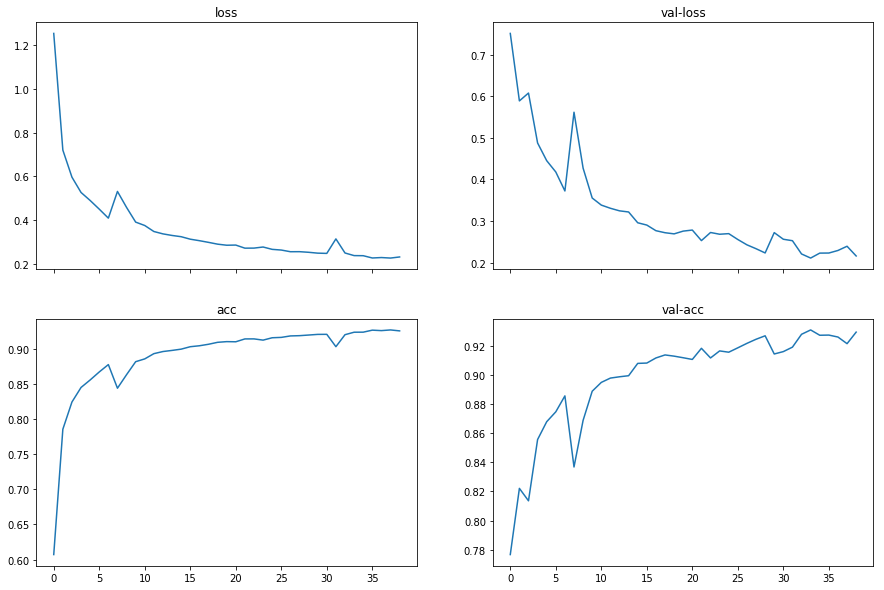

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")

ax[0, 0].plot(history.history['loss'])
ax[0, 1].plot(history.history['val_loss'])
ax[1, 0].plot(history.history['acc'])
ax[1, 1].plot(history.history['val_acc'])

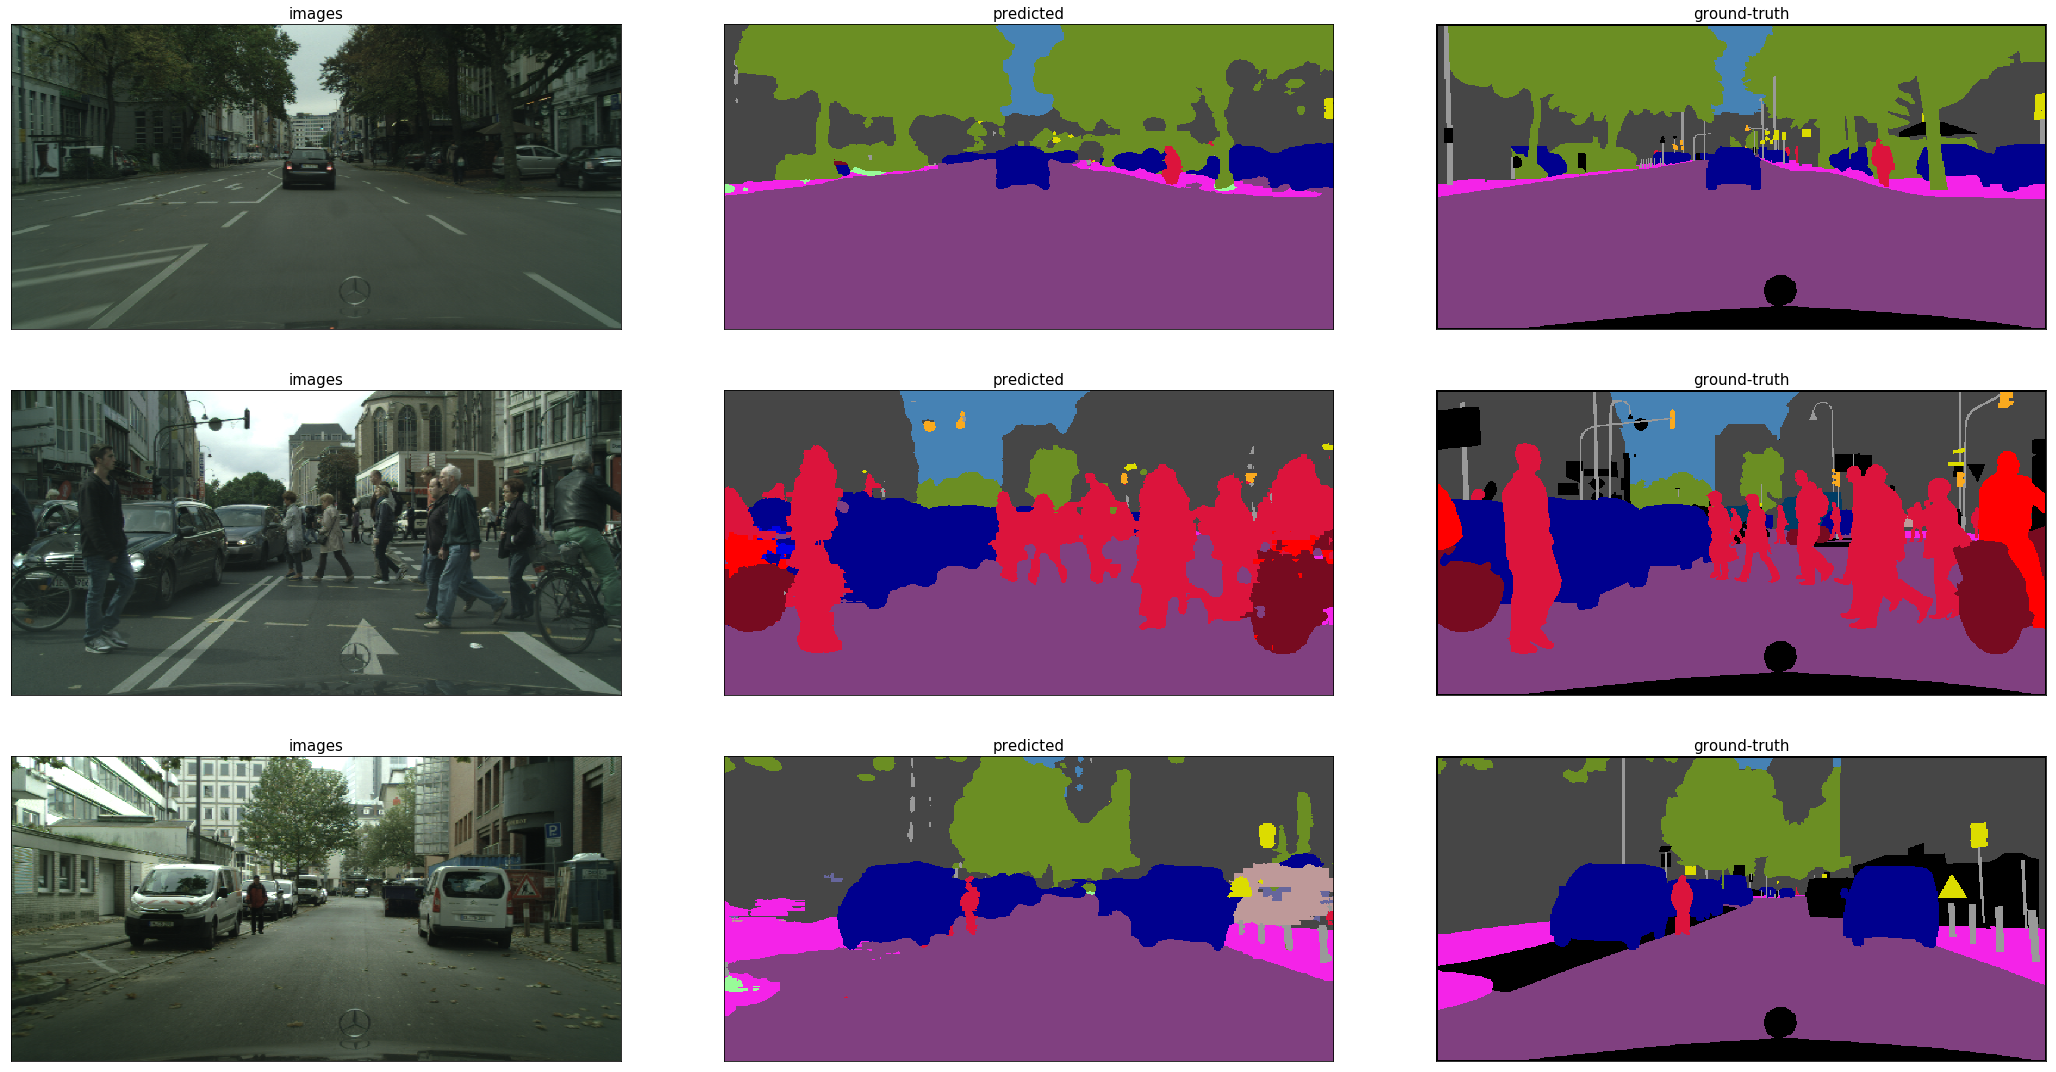

In [21]:
# image_show, predicted_show, gt_show = predict_and_postprocess(input_samples, target_samples)

pred_samples = fcn8s_model.predict(input_samples)
image_show, predicted_show, gt_show = process_for_grid_callback(
    input_samples, pred_samples, target_samples)
figure = plot_image_grid([image_show, predicted_show, gt_show], 
                         titles=["images", "predicted", "ground-truth"])
figure.show()

# imgs, preds, gts = session.run([image_show, predicted_show, gt_show])
# figure = plot_image_grid([imgs[:num_show], preds[:num_show], gts[:num_show]], 
#                          titles=["images", "predicted", "ground-truth"])
# figure.show()

## Weighing the Loss

To prevent our network from ignoring smaller classes, one of the solutions presented in the book was to penalize the network more heavily when misclassifying these classes. This means **weighing the impact of each pixel on the loss, depending on the ground-truth class it belongs to**.

### Per-class weighing

To do so, we first need to have a better look at the representation of each class in our dataset. The following block of codes thus loops over the full training set, and counts the **total number of pixels for each class**:

In [22]:
import numpy as np

train_iterator = train_dataset.make_one_shot_iterator()
train_images, train_labels = train_iterator.get_next()

one_hot_labels = tf.to_int32(tf.one_hot(tf.squeeze(train_labels, -1), num_classes))
num_pixels_per_class = tf.reduce_sum(one_hot_labels, axis=[0, 1, 2])

all_pixels_per_class = np.asarray([0] * num_classes)

for i in range(train_steps_per_epoch): # Iterating over full training set
    batch_pixels_per_class = session.run(num_pixels_per_class)
    all_pixels_per_class += batch_pixels_per_class
        
sum_pixels = np.sum(all_pixels_per_class)

We can now compute the proportion for each class. We could then assign a weight to the pixels of each class, inversely proportional to this value:

In [23]:
class_proportions = all_pixels_per_class / sum_pixels
class_weights = sum_pixels / all_pixels_per_class
class_weights_log = np.log(class_weights)

In [24]:
log_begin_red, log_begin_green = '\033[91m', '\033[92m'
log_begin_bold, log_end_format = '\033[1m', '\033[0m'

print('{}{:13} {:5}  →  {:6}  {:13}{}'.format(
    log_begin_bold, 'class', 'propor', 'weight', 'log(weight)', log_end_format))
for label, prop, weight, weight_log in zip(
    CITYSCAPES_LABELS, class_proportions, class_weights, class_weights_log):
    print('{0:13} {4}{1:5.2f}%{6}  →  {5}{2:6.2f}{3:9.2f}{6}'.format(
        label.name, prop * 100, weight, weight_log,
        log_begin_red, log_begin_green, log_end_format))

class         propor  →  weight  log(weight)  
road          38.82%  →    2.58     0.95
sidewalk       5.84%  →   17.11     2.84
building      21.72%  →    4.60     1.53
wall           0.63%  →  158.79     5.07
fence          0.87%  →  114.54     4.74
pole           1.25%  →   79.91     4.38
traffic light  0.21%  →  480.89     6.18
traffic sign   0.56%  →  179.56     5.19
vegetation    15.56%  →    6.43     1.86
terrain        1.13%  →   88.46     4.48
sky            3.45%  →   28.97     3.37
person         1.34%  →   74.72     4.31
rider          0.15%  →  650.68     6.48
car            7.14%  →   14.01     2.64
truck          0.29%  →  350.52     5.86
bus            0.26%  →  392.08     5.97
train          0.25%  →  396.33     5.98
motorcycle     0.11%  →  950.90     6.86
bicycle        0.43%  →  233.63     5.45


We could directly use the inversed weights (column `weight`), though the disparity looks much too big. Multiplying the impact of some pixels by almost 1,000 would put too much emphasis on these classes, and we would probably not end up with a more nuanced model. We will _squash_ a bit these weights, using their _log_ values instead.

**Note:** It is difficult to have any foresight in such cases. We know here that the log values are a bit better simply from trying with the normal ones before. We are just skipping this step in the notebook to save some time. Refining models means a lot of trials and errors...

**Note:** We opted here to weigh the classes according to their pixel proportions, to balance our network. Other strategies may be chosen to set the weights. For instance, in many applications, it can be **more critical to properly identify/segment some classes rather than others** (even in our current use-case, we probably want our network to clearly identify pedestrians/bikers/etc. to avoid accidents, while we may not mind if some sky patches are mistaken with something else). As mentioned in Chapter 6, another common strategy is to add **more weight to the pixels at the boundaries between elements**. Made popular by the _U-Net_ authors[$^4$](#ref), this strategy can help obtaining masks which are more clearly separated (e.g., if we want to post-process them to identify _instances_). In an [Appendix](#appendix) at the end of this document, we present a simple solution to compute **outline weight maps**, as example.

Anyhow, we now have our **per-class weights**. The next step is to update our loss function to take them into account. Thankfully, `tf.losses.sparse_softmax_cross_entropy()` already accepts an optional `weights` parameter, and can do the weighing of the cross-entropy loss for us. We only need first to use our per-class weights to obtain a **per-pixel weight map**, given a ground-truth label map:

In [25]:
class_weights_log_tf = tf.constant(class_weights_log, 
                               name='cityscapes_class_weights', dtype=tf.float32)

def prepare_class_weight_map(y_true, weights=class_weights_log_tf):
    """
    Prepare pixel weight map based on class weighing.
    :param y_true:        Ground-truth label map(s) (e.g., of shape B x H x W)
    :param weights:       1D tensor of shape (N,) containing the weight value for each of the N classes
    :return:              Weight map (e.g., of shape B x H x W)
    """
    y_true_one_hot = tf.one_hot(y_true, tf.shape(weights)[0])
    weight_map = tf.tensordot(y_true_one_hot, weights, axes=1)
    return weight_map


def weighted_segmentation_loss(y_true, y_pred, 
                               weights=class_weights_log_tf, ignore_value=CITYSCAPES_IGNORE_VALUE):
    """
    Prepare predicted logits and ground-truth maps for the loss, removing pixels from ignored classes.
    :param y_true:        Ground-truth label map(s) (e.g., of shape B x H x W)
    :param y_pred:        Predicted logit map(s) () (e.g., of shape B x H x W x N, N number of classes)
    :param weights:       1D tensor of shape (N,) containing the weight value for each of the N classes
    :param ignore_value:  trainID value of ignored classes (`None` if ignored none) 
    :return:              Loss
    """
    with tf.name_scope('weighted_segmentation_loss'):
        num_classes = y_pred.shape[-1]
        y_true, y_pred = prepare_data_for_segmentation_loss(y_true, y_pred,
                                                            num_classes=num_classes, ignore_value=ignore_value)
        weight_map = prepare_class_weight_map(y_true, weights)

        loss = tf.losses.sparse_softmax_cross_entropy(labels=y_true, logits=y_pred, weights=weight_map,
                                                      reduction=tf.losses.Reduction.MEAN)
    return loss

Let us visualize what thse weight maps may look like, given some ground-truth label maps:

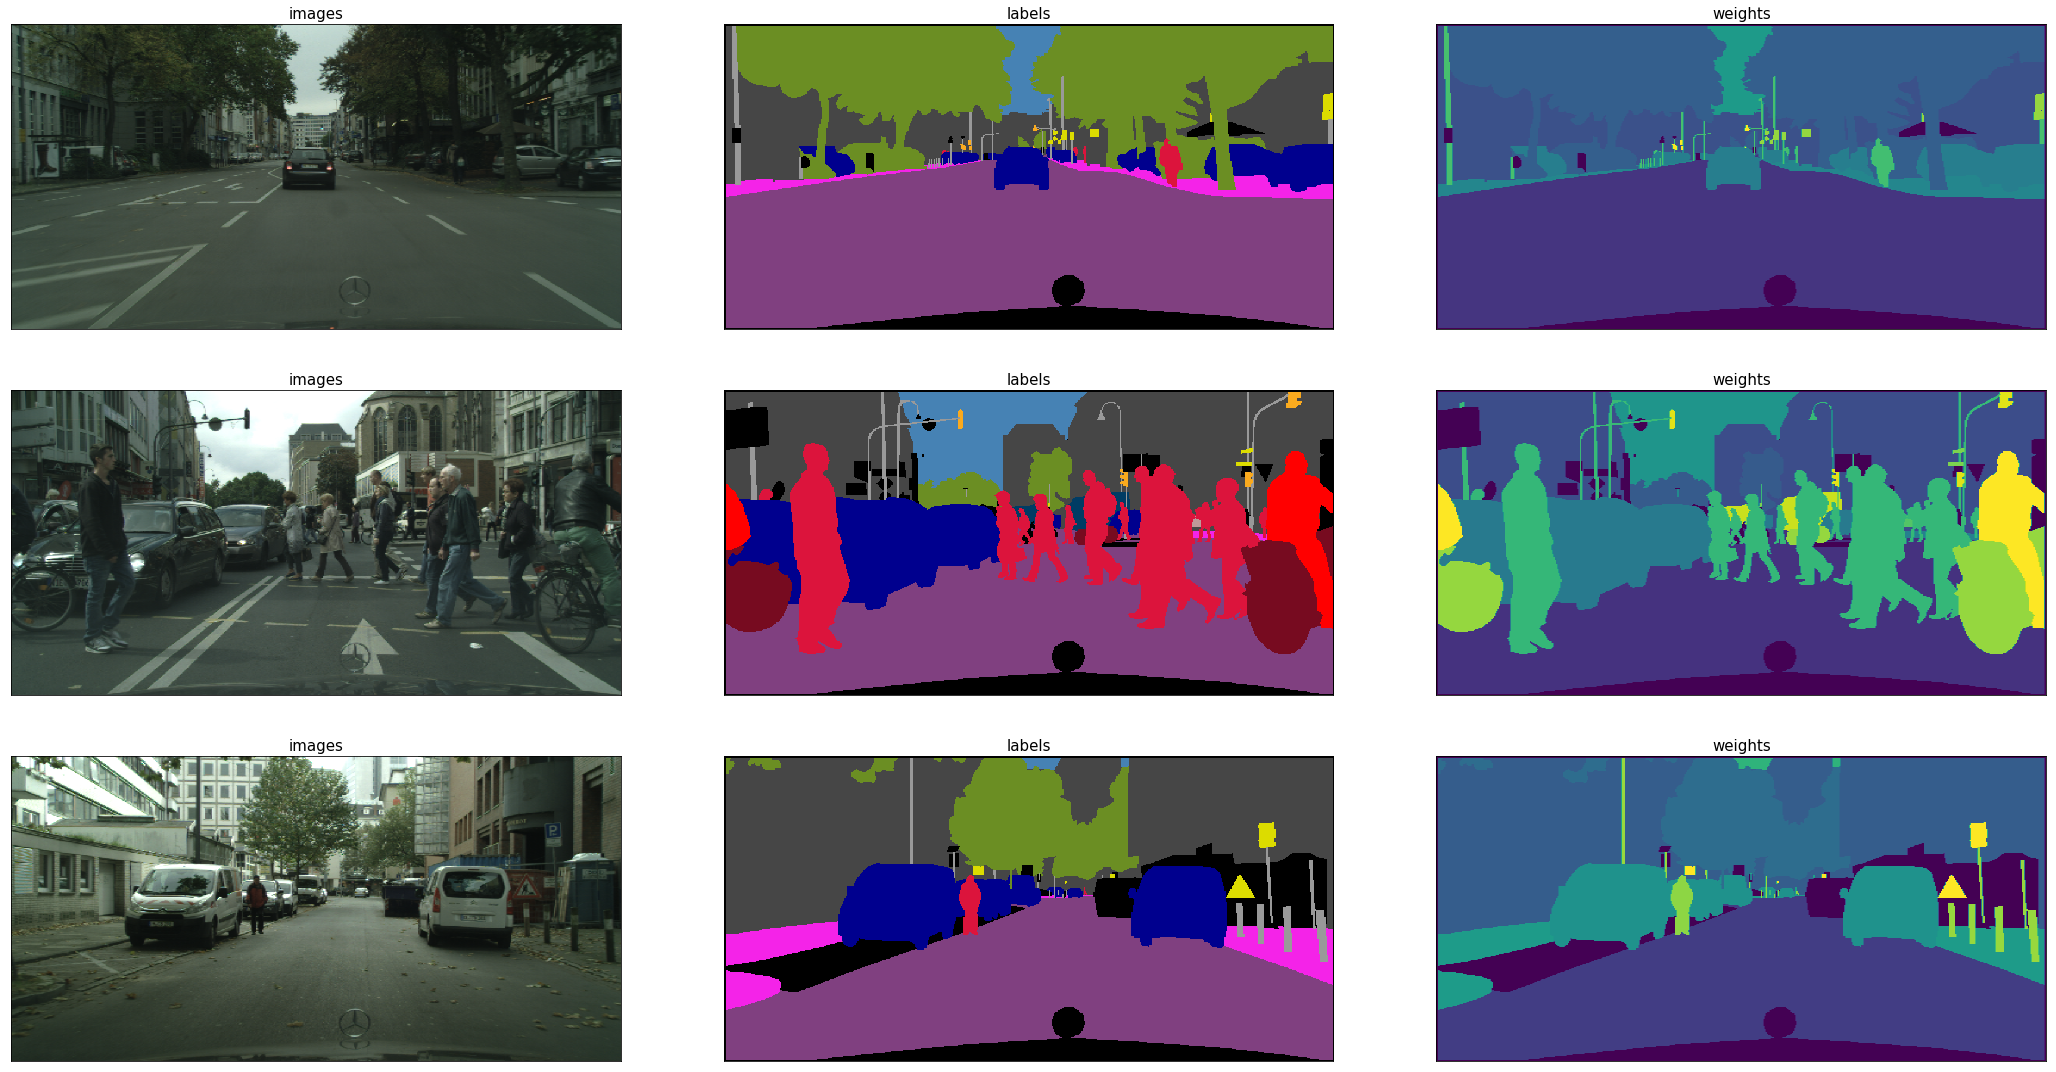

In [27]:
val_iterator = val_dataset.make_one_shot_iterator()
val_images, val_labels = val_iterator.get_next()

image_show = postprocess_to_show(val_images)

val_weight_maps = prepare_class_weight_map(val_labels, class_weights_log_tf)
val_weight_maps = val_weight_maps / tf.reduce_max(val_weight_maps)
weight_show, gt_show = postprocess_to_show(val_weight_maps, val_labels)

images, label_maps, weight_maps = session.run([image_show, gt_show, 
                                               tf.squeeze(weight_show)])
figure = plot_image_grid([images[:num_show], label_maps[:num_show], weight_maps[:num_show]], 
                         titles=["images", "labels", "weights"])
figure.show()

This looks good! As we can see, elements belonging to some of the smaller classes are emphasized by our weighing strategy. With the corresponding loss ready, we can retrain/fine-tune our model. 

### Training

Let us further train our model with this custom loss:

In [28]:
# fcn8s_model = fcn_8s(image_size, num_channels, num_classes)

optimizer = tf.keras.optimizers.Adam()

model_dir = './models/cityscapes_fcn8s_weighted'
callbacks = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model (e.g., every 5 epochs), specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5),
    # Callback to print compacted metrics at the end of each epoch:
    callback_simple_log,
    # Callback to log some validation results as image grids into TensorBoard:
    TensorBoardImageGridCallback(
        log_dir=model_dir, input_images=input_samples, target_images=target_samples, 
        preprocess_fn=process_for_grid_callback,
        tag='cityscapes_fcn8s_weighted_results', figsize=(15, 15))
]

fcn8s_model.compile(optimizer=optimizer, loss=weighted_segmentation_loss, 
                     metrics=[segmentation_accuracy, mean_iou_metric(num_classes)])

history_weighted = fcn8s_model.fit(
    train_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_dataset, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

Training: start.
Epoch  0/90: loss = 0.398; val-loss = 0.371; acc = 0.918; val-acc = 0.919; mIoU = 0.542; val-mIoU = 0.555
Epoch  1/90: loss = 0.385; val-loss = 0.381; acc = 0.919; val-acc = 0.917; mIoU = 0.560; val-mIoU = 0.561
Epoch  2/90: loss = 0.390; val-loss = 0.384; acc = 0.918; val-acc = 0.918; mIoU = 0.562; val-mIoU = 0.563
Epoch  3/90: loss = 0.410; val-loss = 0.355; acc = 0.914; val-acc = 0.925; mIoU = 0.561; val-mIoU = 0.561
Epoch  4/90: loss = 0.383; val-loss = 0.332; acc = 0.918; val-acc = 0.926; mIoU = 0.563; val-mIoU = 0.564
Epoch  5/90: loss = 0.375; val-loss = 0.406; acc = 0.920; val-acc = 0.910; mIoU = 0.566; val-mIoU = 0.567
Epoch  6/90: loss = 0.368; val-loss = 0.338; acc = 0.921; val-acc = 0.921; mIoU = 0.568; val-mIoU = 0.570
Epoch  7/90: loss = 0.363; val-loss = 0.336; acc = 0.922; val-acc = 0.926; mIoU = 0.571; val-mIoU = 0.574
Epoch  8/90: loss = 0.352; val-loss = 0.333; acc = 0.923; val-acc = 0.928; mIoU = 0.575; val-mIoU = 0.577
Epoch  9/90: loss = 0.377; va

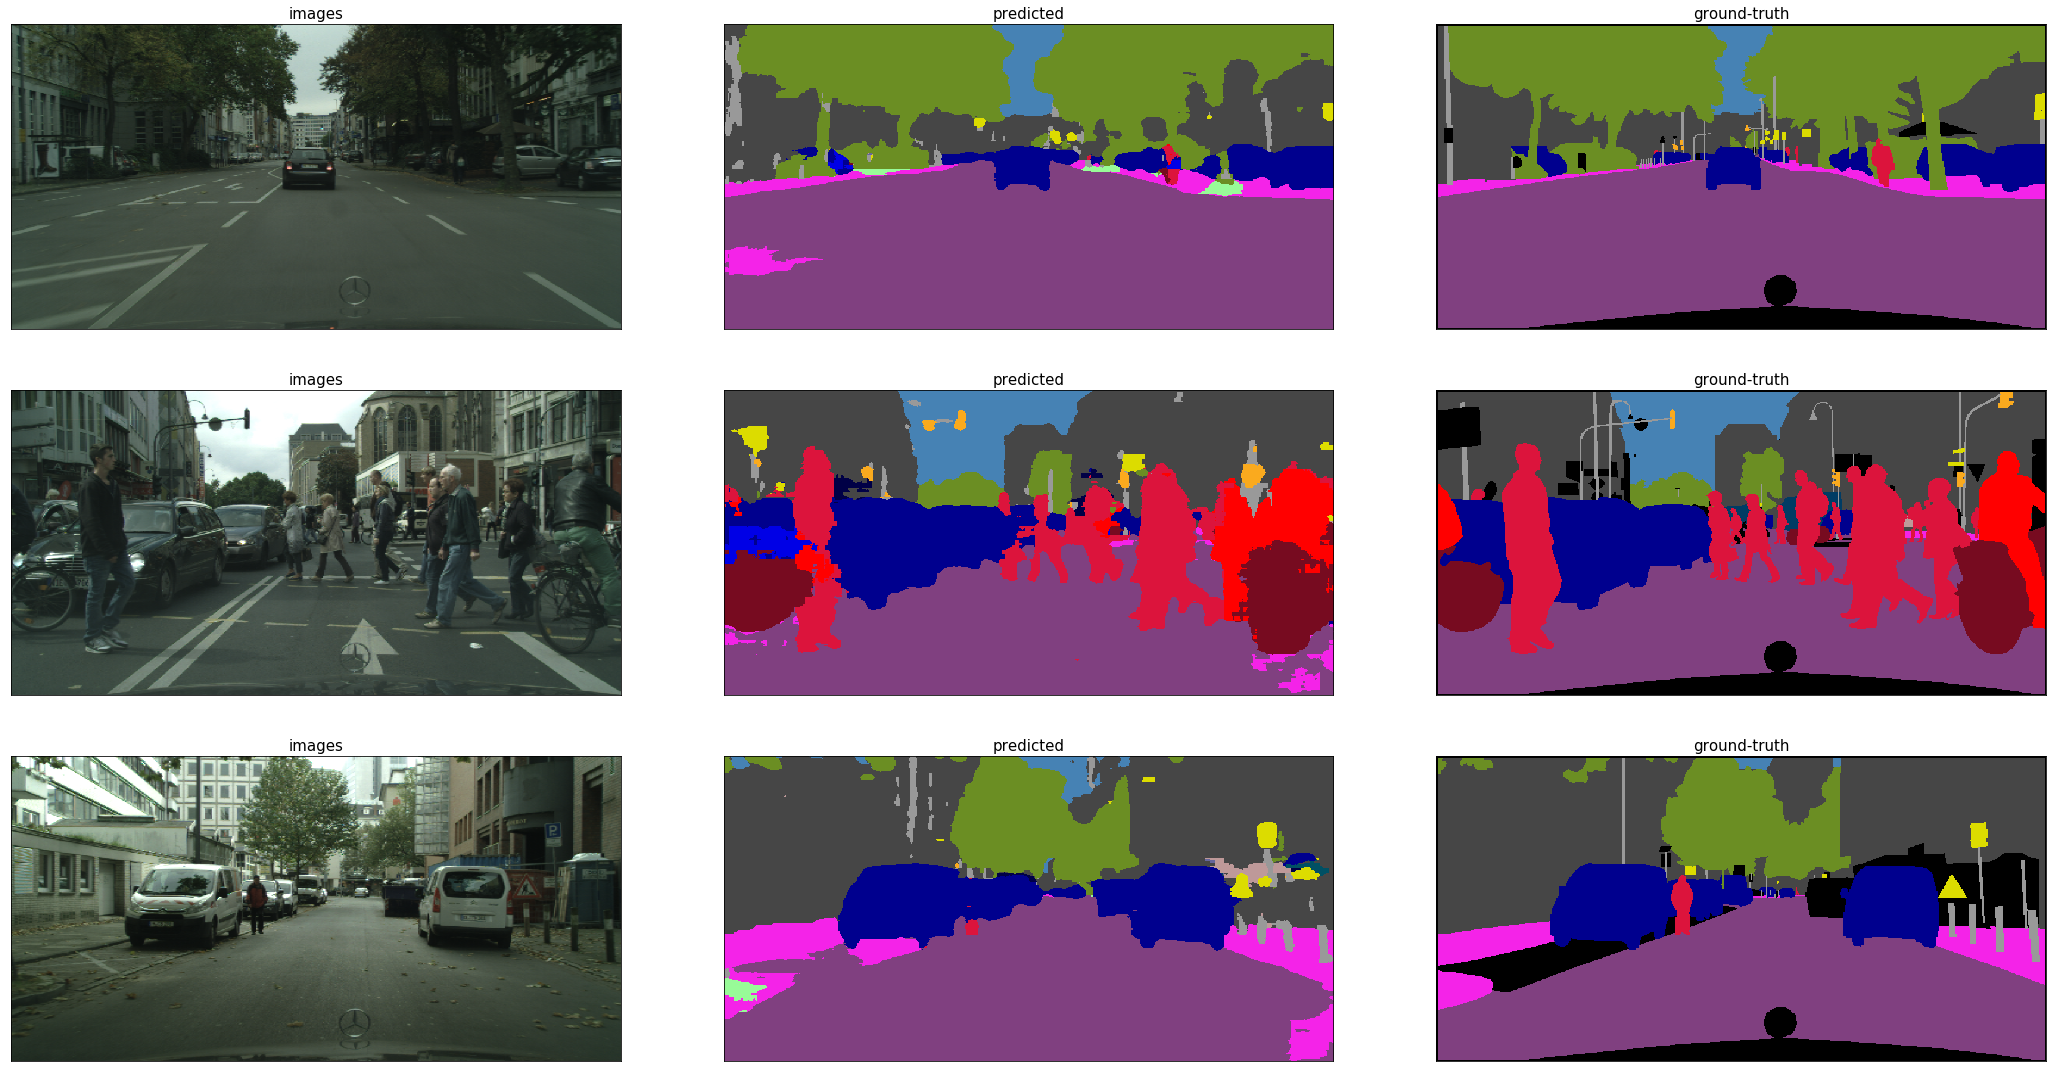

In [29]:
# image_show, predicted_show, gt_show = predict_and_postprocess(input_samples, target_samples)

pred_samples = fcn8s_model.predict(input_samples)
image_show, predicted_show, gt_show = process_for_grid_callback(
    input_samples, pred_samples, target_samples)
figure = plot_image_grid([image_show, predicted_show, gt_show], 
                         titles=["images", "predicted", "ground-truth"])
figure.show()

# imgs, preds, gts = session.run([image_show, predicted_show, gt_show])
# figure = plot_image_grid([imgs[:num_show], preds[:num_show], gts[:num_show]], 
#                          titles=["images", "predicted", "ground-truth"])
# figure.show()

## Conclusion

We covered a lot of ground in this notebook. Targeting the famous Cityscapes dataset for autonomous vehicles, we built and trained our first model for object segmentation. We implemented the _FCN-8s_ architecture, as well as multiple additional losses and metrics to guide the training. Finally, we learned how to weigh the loss function, to put some emphasis on specific classes or image regions.

In the next notebook, we will once again tackle semantic segmentation for smart cars. Using a _U-Net_ this time, we will cover different tools, like the _Dice_ loss and _CRF_ post-processing, and have a try at _instance segmentation_.

<a id="ref"></a>
#### References

1. Cordts, M., Omran, M., Ramos, S., Rehfeld, T., Enzweiler, M., Benenson, R., Franke, U., Roth, S., Schiele, B., 2016. The Cityscapes Dataset for Semantic Urban Scene Understanding. In: 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). Presented at the 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), IEEE, Las Vegas, NV, USA, pp. 3213–3223.
2. Shelhamer, E., Long, J., Darrell, T., 2017. Fully Convolutional Networks for Semantic Segmentation. IEEE Transactions on Pattern Analysis and Machine Intelligence 39, 640–651.
3. Simonyan, K., Zisserman, A., 2014. Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv:1409.1556 [cs].
4. Ronneberger, O., Fischer, P., Brox, T., 2015. U-Net: Convolutional Networks for Biomedical Image Segmentation. arXiv:1505.04597 [cs].

<a id="appendix"></a>
## Appendix - Outline Weighing

As explained in the chapter and notebook, there are many ways of weighing the loss to guide the model's training. Focusing on the segmentation of neuronal cells, _U-Net_ authors suggested to add more weight to the pixels at the boundary between several cells. This allowed them to obtain masks with the cell instances beter separated.

In this appendix, we will present a really simple way of obtaining weight maps emphasizing the classes' borders, using morphological operations on the ground-truth label maps.

**Note:** for those who are interested in the more advanced weight computations proposed by the _U-Net_ authors, we suggest to check their paper[$^4$](#ref), or this well-written [notebook](https://jaidevd.github.io/posts/weighted-loss-functions-for-instance-segmentation/) by Jaidev Deshpande.

### Morphological operations for binary tensors

_Dilation_ and _erosion_ of binary matrices are among the simplest morphological operations:

In [30]:
# | 0  0  0  0  0 |               | 0  0  0  0  0 |
# | 0  0  0  0  0 |   dilation    | 1  1  1  1  0 |
# | 0  1  1  0  0 | ------------> | 1  1  1  1  0 |
# | 0  0  1  0  0 |               | 1  1  1  1  0 |
# | 0  0  0  0  0 |               | 0  1  1  1  1 |
# | 0  0  0  0  1 |               | 0  0  0  1  1 |

In [31]:
# | 1  0  1  0  0 |               | 0  0  0  0  0 |
# | 0  1  1  1  0 |    erosion    | 0  0  0  0  0 |
# | 1  1  1  1  1 | ------------> | 0  0  1  0  0 |
# | 1  1  1  1  1 |               | 1  1  1  0  0 |
# | 1  1  1  1  0 |               | 0  0  0  0  0 |
# | 0  0  0  1  0 |               | 0  0  0  0  0 |

Advantageously, these operations on binary tensors can be implemented with simple convolutions and clipping:

In [32]:
def binary_dilation(x, kernel_size=3):
    """
    Apply dilation of the given binary tensor (each input channel is processed independently)
    :param x:               Binary tensor of shape BxHxWxC
    :param kernel_size:     Kernel size  (int or Tensor)
    :return:                Dilated Tensor
    """
    with tf.name_scope("binary_dilation"):
        num_channels = tf.shape(x)[-1]
        kernel = tf.ones((kernel_size, kernel_size, num_channels, 1), dtype=x.dtype)
        conv = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], padding='SAME')
        clip = tf.clip_by_value(conv, 1., 2.) - 1.
        return clip


def binary_erosion(x, kernel_size=3):
    """
    Apply erosion of the given binary tensor (each input channel is processed independently)
    :param x:              Binary tensor of shape BxHxWxC or HxWxC (if is_single_image)
    :param kernel_size:    Kernel size  (int or Tensor)
    :return:               Eroded Tensor
    """
    with tf.name_scope("binary_erosion"):
        num_channels = tf.shape(x)[-1]
        kernel = tf.ones((kernel_size, kernel_size, num_channels, 1), dtype=x.dtype)
        conv = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], padding='SAME')
        max_val = tf.constant(kernel_size * kernel_size, dtype=x.dtype)
        clip = tf.clip_by_value(conv, max_val - 1, max_val)
        return clip - (max_val - 1)

These two operations can be combined into more advanced morphological operations like _opening_, _closing_, and more importantly for us, **_outline extraction_**:

In [33]:
def binary_opening(tensor, kernel_size=3):
    """
    Apply opening of the given binary tensor (each input channel is processed independently)
    :param tensor:                  Binary tensor of shape BxHxWxC or HxWxC (if is_single_image)
    :param kernel_size:             Kernel size  (int or Tensor)
    :return:                        Tensor
    """
    with tf.name_scope("binary_opening"):
        return binary_dilation(binary_erosion(tensor, kernel_size), kernel_size)


def binary_closing(x, kernel_size=3):
    """
    Apply closing of the given binary tensor (each input channel is processed independently)
    :param tensor:                  Binary tensor of shape BxHxWxC or HxWxC (if is_single_image)
    :param kernel_size:             Kernel size  (int or Tensor)
    :return:                        Tensor
    """
    with tf.name_scope("binary_opening"):
        return binary_erosion(binary_dilation(x, kernel_size), kernel_size)
    

def binary_outline(x, kernel_size=3):
    """
    Compute the outline (cf. cv2.morphologyEx) of the given binary tensor
    (each input channel is processed independently)
    :param x:                  Binary tensor of shape BxHxWxC or HxWxC (if is_single_image)
    :param kernel_size:        Kernel size  (int or Tensor)
    :return:                   Tensor
    """
    with tf.name_scope("binary_outline"):
        return binary_dilation(x, kernel_size) - binary_erosion(x, kernel_size)

Let us have a look what this last operation would return on our ground-truth label maps. We pick for instance the binary mask corresponding to the "_road_" class (from a one-hot label map), and apply our outline method to it:

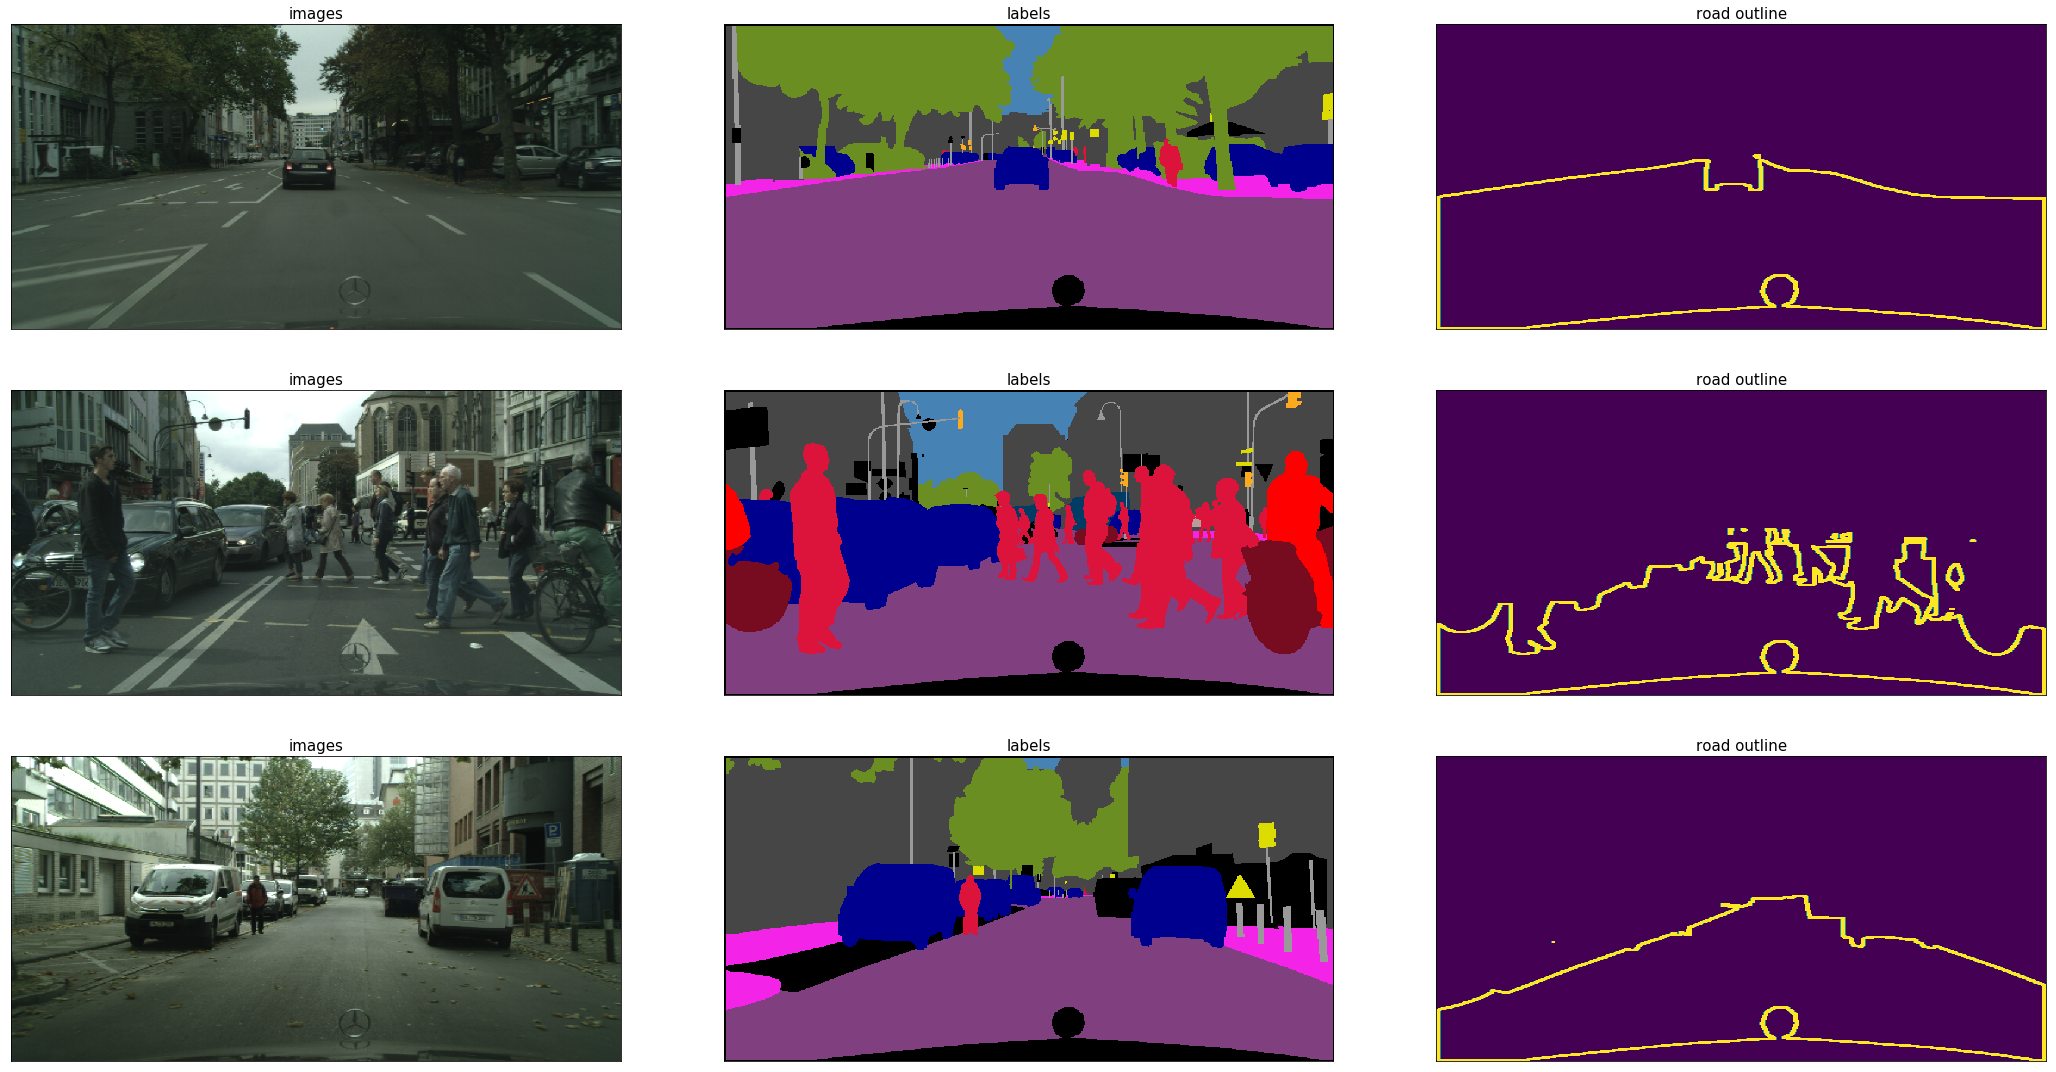

In [38]:
road_id = 0

val_iterator = val_dataset.make_one_shot_iterator()
val_images, val_labels = val_iterator.get_next()

image_show, gt_show = postprocess_to_show(val_images, val_labels)

val_labels_onehot = tf.squeeze(tf.one_hot(val_labels, num_classes))
val_labels_outline = tf.to_int32(binary_outline(val_labels_onehot, kernel_size=5))
val_road_outline = tf.expand_dims(val_labels_outline[..., road_id], -1)

outline_show = postprocess_to_show(val_road_outline)

images, label_maps, outline_maps = session.run([image_show, gt_show, 
                                               tf.squeeze(outline_show)])
figure = plot_image_grid([images[:num_show], label_maps[:num_show], outline_maps[:num_show]], 
                         titles=["images", "labels", "road outline"])
figure.show()

As we can see, we indeed managed to extract the outlines of this class in our images. Now, let us implement a method to compute complete weight maps based on the outline of all classes:

In [36]:
def prepare_outline_weight_map(y_true, num_classes, outline_size=5,
                               outline_val=4., default_val=1.):
    """
    Prepare pixel weight map based on class outlines.
    :param y_true:        Ground-truth label map(s) (e.g., of shape B x H x W)
    :param num_classes:   Number of classes
    :param outline_size:  Outline size/thickness
    :param outline_val:   Weight value for outline pixels
    :param default_val:   Weight value for other pixels
    :return:              Weight map (e.g., of shape B x H x W)
    """
    y_true_one_hot = tf.squeeze(tf.one_hot(y_true, num_classes), axis=-2)
    outline_map_perclass = binary_outline(y_true_one_hot, outline_size)
    outline_map = tf.reduce_max(outline_map_perclass, axis=-1)
    outline_map = outline_map * (outline_val - default_val) + default_val
    return outline_map

Visualization:

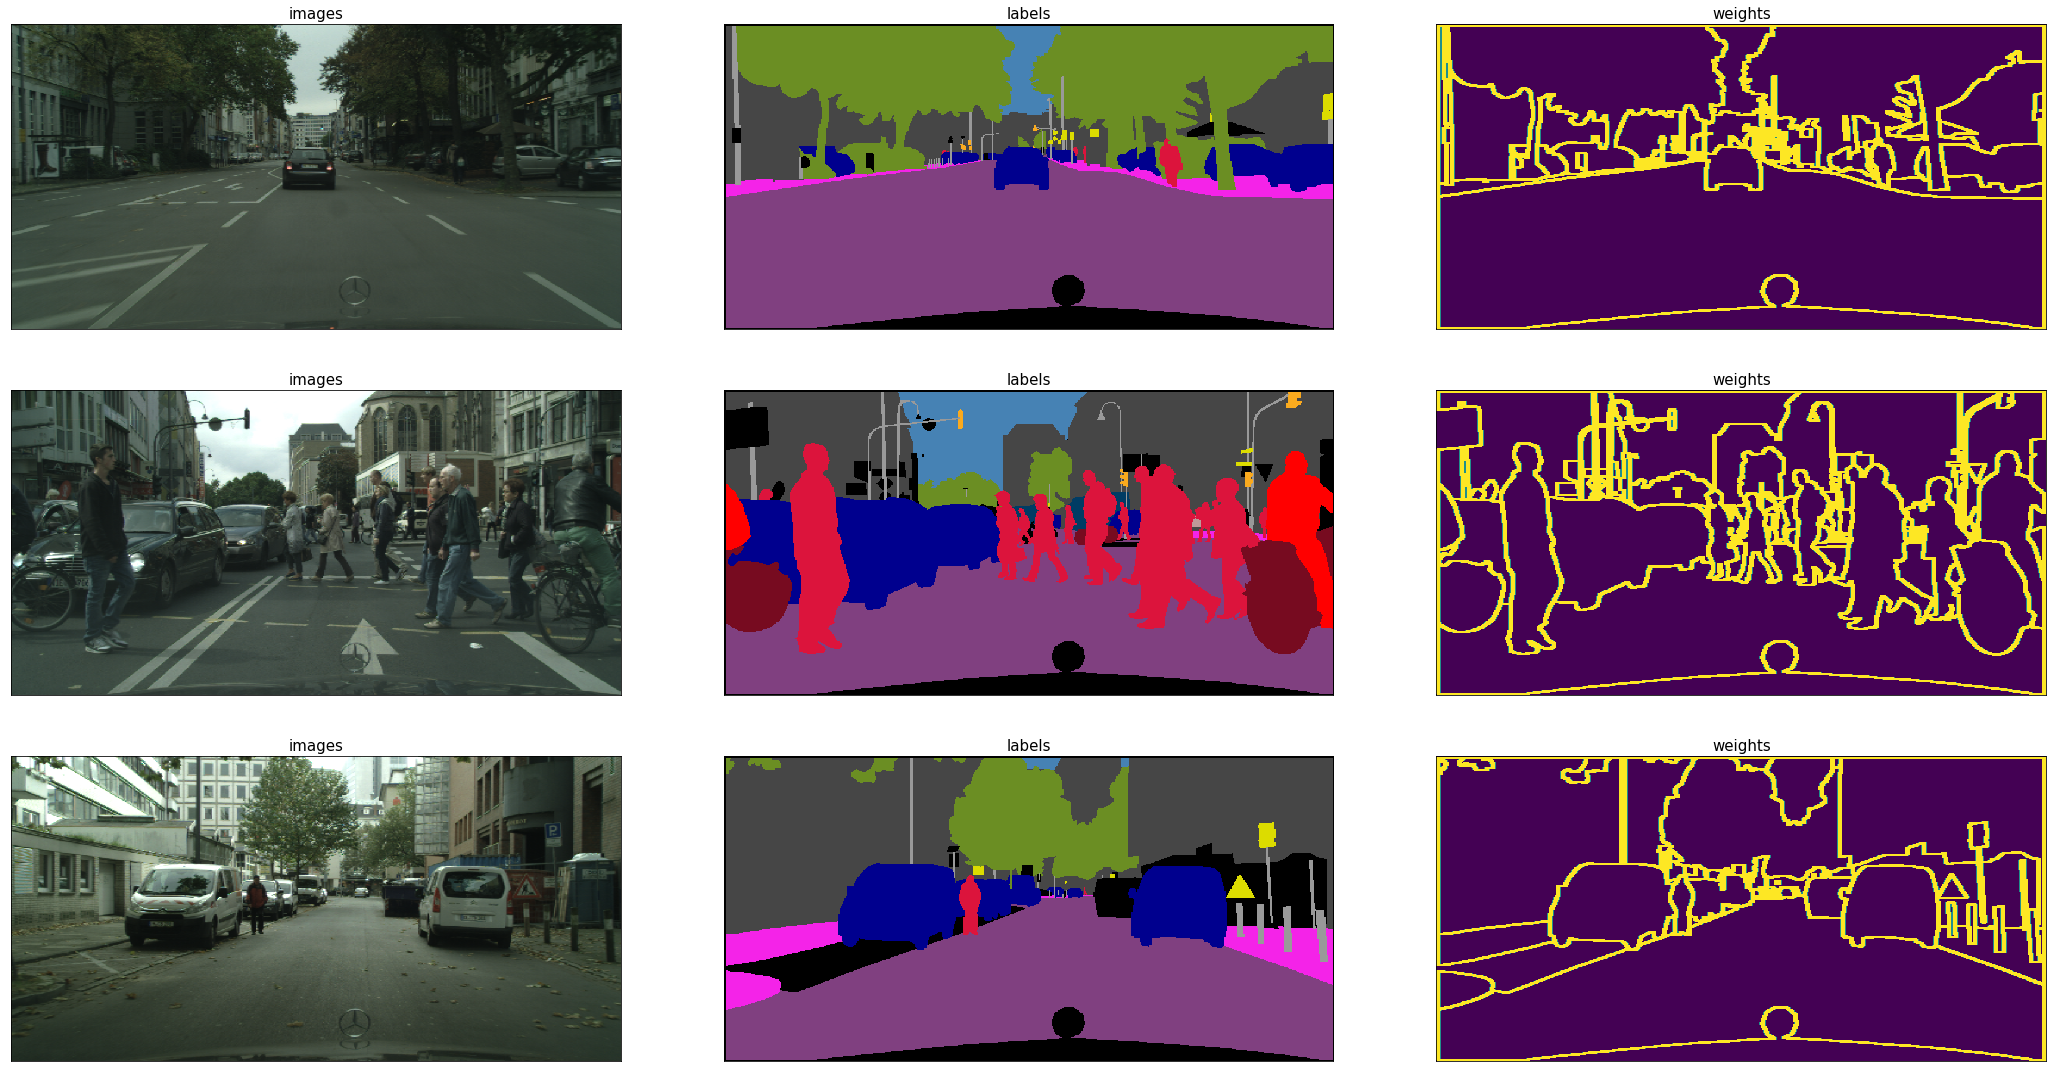

In [39]:
val_iterator = val_dataset.make_one_shot_iterator()
val_images, val_labels = val_iterator.get_next()

image_show, gt_show = postprocess_to_show(val_images, val_labels)

# Let us create maps where outline pixels have their weight equals to 4
# and other pixels have their weght left to 1:
val_weight_maps = prepare_outline_weight_map(val_labels, num_classes, 5,
                                             outline_val=4., default_val=1.)

val_weight_maps = val_weight_maps / tf.reduce_max(val_weight_maps)
weight_show = postprocess_to_show(tf.expand_dims(val_weight_maps, -1))

images, label_maps, weight_maps = session.run([image_show, gt_show, 
                                               tf.squeeze(weight_show)])
figure = plot_image_grid([images[:num_show], label_maps[:num_show], weight_maps[:num_show]], 
                         titles=["images", "labels", "weights"])
figure.show()

The same way we used `prepare_class_weight_map()` in our custom loss function with per-clas weighing, we could now define another loss function using this `prepare_outline_weight_map()` instead.